# Lamda Simulation

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.ops.indexing import Vindex
from pyro import param
from torch.distributions import constraints
from torch.distributions.utils import probs_to_logits
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.io import savemat
%load_ext autoreload
%autoreload 2

In [2]:
from tapqir.distributions import AffineBeta
from tapqir.utils.dataset import CosmosDataset
from tapqir.models import FixedOffset, GaussianSpot
from pyro.infer import Predictive

In [9]:
S = 1
K = 2
N = 15 # number of AOIs
D = 14 # AOI size
F = 500 # number of frames
offset = torch.full((100,), 90.)
target = pd.DataFrame(data={"frame": np.zeros(N), "x": 6.5, "y": 6.5}, index=np.arange(N))
target.index.name = "aoi"
drift = pd.DataFrame(data={"dx": 0., "dy": 0}, index=np.arange(F))
drift.index.name = "frame"
data = CosmosDataset(torch.zeros(N,F,D,D), target, drift,
                     dtype="test", device=torch.device("cuda"), offset=offset)
control = CosmosDataset(torch.zeros(N,F,D,D), target, drift,
                     dtype="control", device=torch.device("cuda"))

In [10]:
pyro.get_param_store().clear()
param("gain", torch.tensor(7.), constraint=constraints.positive)
param("offset", torch.tensor(90.), constraint=constraints.positive)
param("height_loc", torch.tensor(3000.), constraint=constraints.positive)
param("probs_z", torch.tensor([0.85, 0.15]), constraint=constraints.simplex)
param("rate_j", torch.tensor(0.5), constraint=constraints.positive)
param("proximity", torch.tensor([0.2]), constraint=constraints.positive)
model = FixedOffset(S, K)
model.data = data
model.data_loc = GaussianSpot(model.data.target, model.data.drift, model.data.D)
model.control = control
model.control_loc = GaussianSpot(model.control.target, model.control.drift, model.control.D)
simulation = {
    "d/background": torch.full((1,N,1), 150.),
    "d/state": torch.full((1,N,F), 4, dtype=torch.long),
    "d/height": torch.cat((torch.linspace(1,3000,500).reshape(1,1,F,1).repeat(1,N,1,1), torch.zeros(1,N,F,1)), -1),
    "d/width": torch.full((1,N,F,2), 1.4),
    "c/background": torch.full((1,N,1), 150.),
    "c/width": torch.full((1,N,F,2), 1.4),
}
predictive = Predictive(model.model, posterior_samples=simulation, num_samples=None)

In [11]:
samples = predictive()

In [14]:
model.data.data = samples["d/data"][0].data
# model.control.data = samples["c/data"][0].data
model.data.labels = np.zeros((N, F), dtype=[("aoi", int), ("frame", int), ("z", bool)])
model.data.labels["aoi"] = np.arange(N).reshape(-1, 1)
model.data.labels["frame"] = np.arange(F)
model.data.labels["z"] = 1
# model.data.labels["z"] = Vindex(model.state_to_z)[samples["d/state"]][0].sum(-1)

In [15]:
path_data = "/shared/centaur/data/simulations/lamda_data/hfloatpi100lamda0"
model.data.save(path_data)
model.control.save(path_data)

In [8]:
path_data = "/shared/centaur/data/simulations/lamda_data/h3000pi15lamda50"
model.data.save(path_data)
model.control.save(path_data)

In [8]:
samples.keys()

dict_keys(['d/state', 'd/height', 'd/x', 'd/y', 'd/data'])

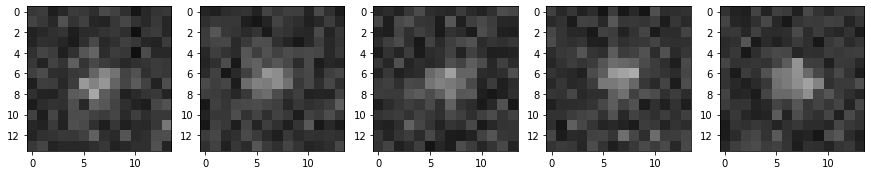

In [17]:
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(model.data[0,i+405], vmin=samples["d/data"].min(), vmax=samples["d/data"].max(), cmap="gray")
plt.show()

In [10]:
Vindex(model.state_to_z)[samples["d/state"]].sum(-1)[0,0,105:115]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

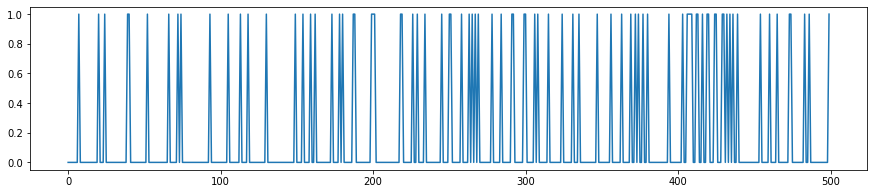

In [11]:
plt.figure(figsize=(15,3))
plt.plot(Vindex(model.state_to_z)[samples["d/state"]].sum(-1)[0,0])

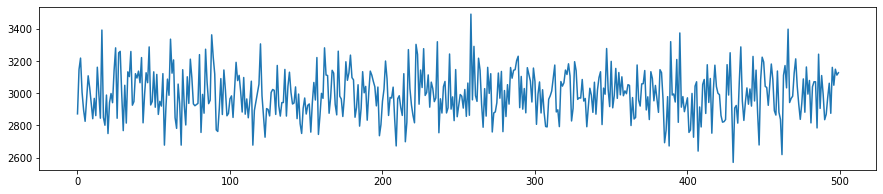

In [12]:
plt.figure(figsize=(15,3))
plt.plot(samples["d/height"][0,0,:,0].data)

In [7]:
sim = "lamda"
h = "3000"
lamda_js = ["01", "03", "15", "50", "85", "99"]
# lamda_js = ["85"]
pi_z = "15"
sigma = "0.2"